In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


# Exercise 2

Your boss was extremely happy with your work on the housing price prediction model and decided to entrust you with a more challenging task. They've seen a lot of people leave the company recently and they would like to understand why that's happening. They have collected historical data on employees and they would like you to build a model that is able to predict which employee will leave next. The would like a model that is better than random guessing. They also prefer false negatives than false positives, in this first phase. Fields in the dataset include:

    Employee satisfaction level
    Last evaluation
    Number of projects
    Average monthly hours
    Time spent at the company
    Whether they have had a work accident
    Whether they have had a promotion in the last 5 years
    Department
    Salary
    Whether the employee has left

Your goal is to predict the binary outcome variable left using the rest of the data. Since the outcome is binary, this is a classification problem. Here are some things you may want to try out:

    load the dataset at ../data/HR_comma_sep.csv, inspect it with .head(), .info() and .describe().

    Establish a benchmark: what would be your accuracy score if you predicted everyone stay?
    Check if any feature needs rescaling. You may plot a histogram of the feature to decide which rescaling method is more appropriate.
    convert the categorical features into binary dummy columns. You will then have to combine them with the numerical features using pd.concat.
    do the usual train/test split with a 20% test size
    play around with learning rate and optimizer
    check the confusion matrix, precision and recall
    check if you still get the same results if you use a 5-Fold cross validation on all the data
    Is the model good enough for your boss?

As you will see in this exercise, the a logistic regression model is not good enough to help your boss. In the next chapter we will learn how to go beyond linear models.

This dataset comes from https://www.kaggle.com/ludobenistant/hr-analytics/ and is released under CC BY-SA 4.0 License.

## Data Preprocessing

In [2]:
df = pd.read_csv('../data/HR_comma_sep.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## One hot encoding

In [5]:
df.sales.value_counts()

sales
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

In [6]:
len(df.sales.unique())

10

In [7]:
df.salary.value_counts()

salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64

In [8]:
# # encode categorical feature to int()
# le = LabelEncoder()
# le.fit(df['sales'])
# list(le.classes_)
# df['sales_encoded'] = le.transform(df['sales'])

In [9]:
# df['sales_encoded'].value_counts()

In [10]:
# one hot encode sales categorical feature and join back to df
df_dummies = pd.get_dummies(df['sales'], prefix='dptmt')
df = df.join(df_dummies, rsuffix='')

In [11]:
# one hot encode salary categorical feature
df_dummies = pd.get_dummies(df['salary'], prefix='salary')
df = df.join(df_dummies, rsuffix='')

In [12]:
# map True False boolean values to int()
columns = df.columns
columns = list(columns)
substring_a = 'dptmt'
substring_b = 'salary'
dummy_features = []
for feature in columns:
    if substring_a in feature:
        dummy_features.append(feature)
    elif substring_b in feature:
        dummy_features.append(feature)

dummy_features.remove('salary')

In [13]:
dummy_features

['dptmt_IT',
 'dptmt_RandD',
 'dptmt_accounting',
 'dptmt_hr',
 'dptmt_management',
 'dptmt_marketing',
 'dptmt_product_mng',
 'dptmt_sales',
 'dptmt_support',
 'dptmt_technical',
 'salary_high',
 'salary_low',
 'salary_medium']

In [14]:
tf_dict = {True:1, False:0}

for feature in dummy_features:
    df[feature] = df[feature].map(tf_dict)

In [15]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,...,dptmt_hr,dptmt_management,dptmt_marketing,dptmt_product_mng,dptmt_sales,dptmt_support,dptmt_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


## Standard Scale on Numeric Features

In [ ]:
# satisfaction level and last evaluation already range in [0,1]
numeric_features = ['number_project', 'average_montly_hours', 'time_spend_company']

In [18]:
for feature in numeric_features:
    ss = StandardScaler()
    feature_ss = str(feature) + '_ss'
    df[feature_ss] = ss.fit_transform(df[[feature]])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   satisfaction_level       14999 non-null  float64
 1   last_evaluation          14999 non-null  float64
 2   number_project           14999 non-null  int64  
 3   average_montly_hours     14999 non-null  int64  
 4   time_spend_company       14999 non-null  int64  
 5   Work_accident            14999 non-null  int64  
 6   left                     14999 non-null  int64  
 7   promotion_last_5years    14999 non-null  int64  
 8   sales                    14999 non-null  object 
 9   salary                   14999 non-null  object 
 10  dptmt_IT                 14999 non-null  int64  
 11  dptmt_RandD              14999 non-null  int64  
 12  dptmt_accounting         14999 non-null  int64  
 13  dptmt_hr                 14999 non-null  int64  
 14  dptmt_management      

In [20]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,...,dptmt_product_mng,dptmt_sales,dptmt_support,dptmt_technical,salary_high,salary_low,salary_medium,number_project_ss,average_montly_hours_ss,time_spend_company_ss
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,1,0,0,0,1,0,-1.462863,-0.882040,-0.341235
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,1,0,0,0,0,1,0.971113,1.220423,1.713436
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,1,0,0,0,0,1,2.593763,1.420657,0.343655
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,1,0,0,0,1,0,0.971113,0.439508,1.028546
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,1,0,0,0,1,0,-1.462863,-0.841993,-0.341235


In [21]:
clean_features = []

# scaled numeric features
for feature in numeric_features:
    feature_ss = str(feature) + '_ss'
    clean_features.append(feature_ss)

# existing boolean features
clean_features.append('Work_accident')
clean_features.append('promotion_last_5years')
clean_features.append('satisfaction_level')
clean_features.append('last_evaluation')


# one-hot encoded salary and dptmt features
for feature in dummy_features:
    clean_features.append(feature)

clean_features

['number_project_ss',
 'average_montly_hours_ss',
 'time_spend_company_ss',
 'Work_accident',
 'promotion_last_5years',
 'satisfaction_level',
 'last_evaluation',
 'dptmt_IT',
 'dptmt_RandD',
 'dptmt_accounting',
 'dptmt_hr',
 'dptmt_management',
 'dptmt_marketing',
 'dptmt_product_mng',
 'dptmt_sales',
 'dptmt_support',
 'dptmt_technical',
 'salary_high',
 'salary_low',
 'salary_medium']

In [22]:
len(clean_features)

20

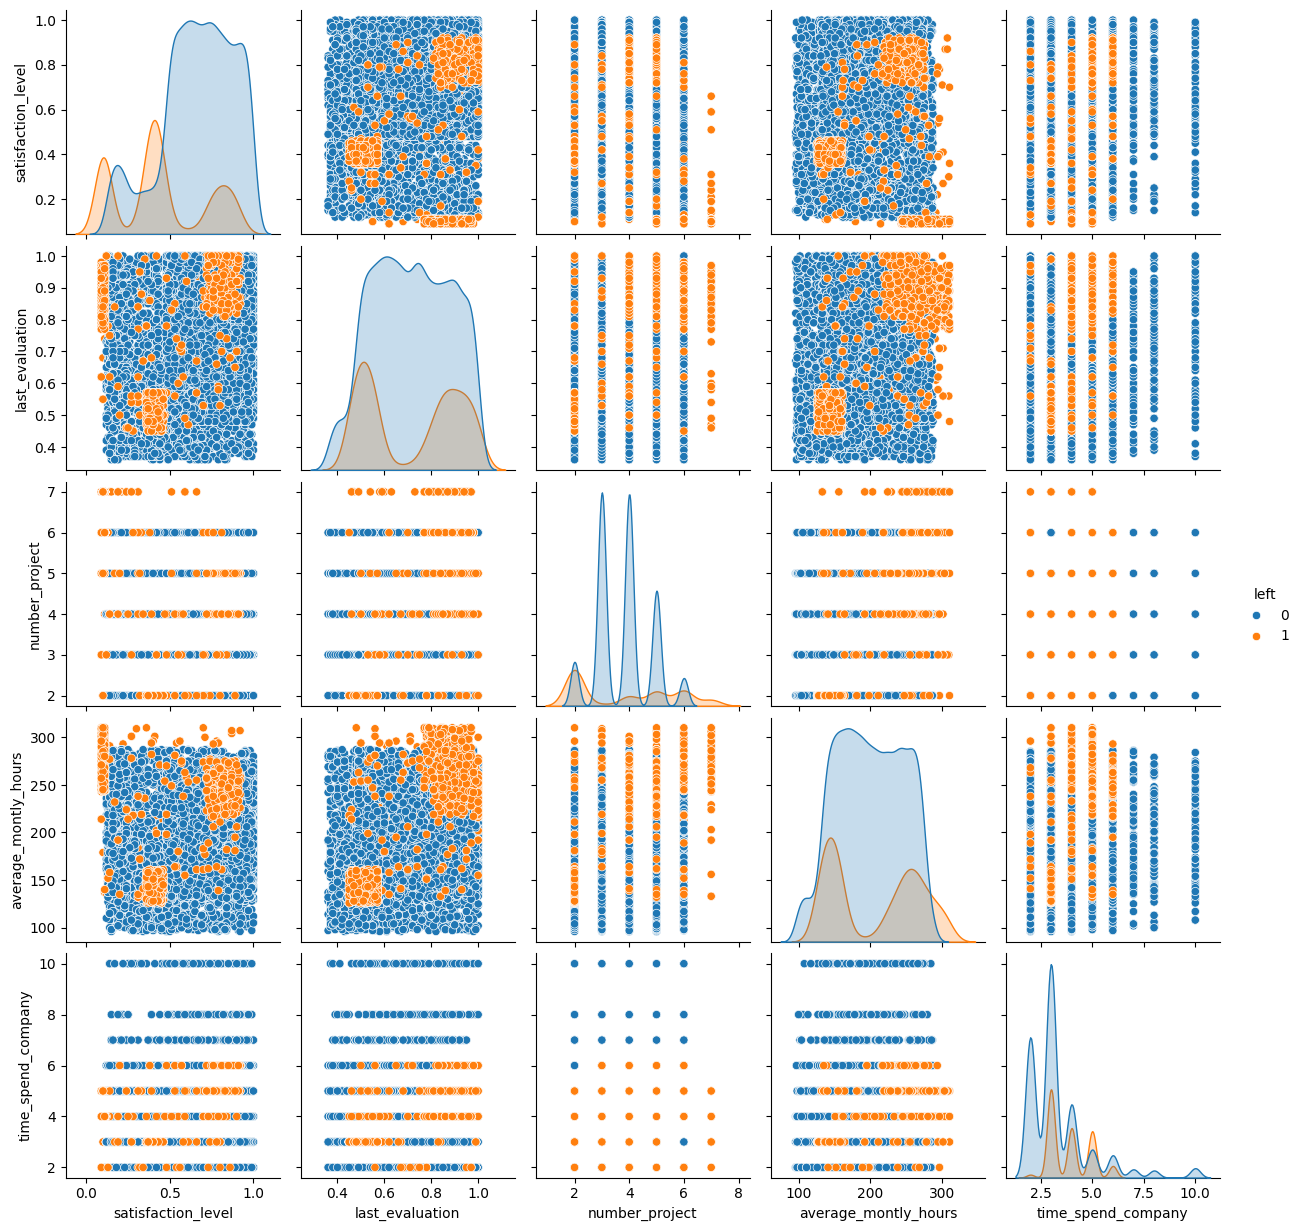

In [23]:
sns.pairplot(df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company','left' ]], hue='left')

monthly hours + last evaluation appear to have some useful information

employees with low satisfaction and low performance evals appear to leave, but there isn't a totally clear pattern

## Gather clean features into features, labels

In [24]:
X = df[clean_features].values
y = df['left'].values

## Train, Test Split

In [25]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Config and Training

In [32]:
model = Sequential()
model.add(Dense(80, input_shape=(20,), activation='relu'))
model.add(Dense(80, activation ='relu'))
model.add(Dense(1, activation ='softmax'))
adam = Adam(learning_rate=0.05)
model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

/Users/thomascampbell/code/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20


/Users/thomascampbell/code/.venv/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.2379 - loss: 0.3013 - val_accuracy: 0.2258 - val_loss: 0.1557
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.2326 - loss: 0.1762 - val_accuracy: 0.2258 - val_loss: 0.1645
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.2358 - loss: 0.1599 - val_accuracy: 0.2258 - val_loss: 0.1692
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.2323 - loss: 0.1557 - val_accuracy: 0.2258 - val_loss: 0.1479
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.2390 - loss: 0.1392 - val_accuracy: 0.2258 - val_loss: 0.1765
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.2380 - loss: 0.1565 - val_accuracy: 0.2258 - val_loss: 0.1880
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.2383 - loss: 0.1318 - val_accuracy: 0.2258 - val_loss: 0.1726
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2348 - loss: 0.1344 - val_accurac

## Model Evaluation

In [41]:
# Our model should have a benchmark of at least 76% accuracy on the test set if it predicted that no one would leave
pd.Series(y_test).value_counts(normalize=True)

0    0.758
1    0.242
Name: proportion, dtype: float64

In [30]:
y_pred = model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


/Users/thomascampbell/code/.venv/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2274
           1       0.24      1.00      0.39       726

    accuracy                           0.24      3000
   macro avg       0.12      0.50      0.19      3000
weighted avg       0.06      0.24      0.09      3000



/Users/thomascampbell/code/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thomascampbell/code/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thomascampbell/code/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [36]:
def pretty_confusion_matrix(y_true, y_pred, labels=['False','True']):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted ' + l for l in labels]
    df = pd.DataFrame(cm,index=labels, columns=pred_labels)
    return df

In [37]:
pretty_confusion_matrix(y_test, y_pred)

,Predicted False,Predicted True
False,0,2274
True,0,726


Model is actually predicting that everyone will leave which is very bad especially given the label imbalance!